In [1]:

# install transformers
!pip install transformers==4.5.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 73.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 104.5 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=32a28d0434308384e43aecf4e80f650223628cace5aed42e1e42d18e12d0c31d
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses


In [2]:
#download dataset
!unzip -o /content/drive/MyDrive/ml2021-spring-hw7.zip

Archive:  /content/drive/MyDrive/ml2021-spring-hw7.zip
  inflating: hw7_dev.json            
  inflating: hw7_test.json           
  inflating: hw7_train.json          


In [3]:
import json

def read_data(path):
    with open(path,'r',encoding='utf-8') as reader:
        data=json.load(reader)
        return data['questions'],data['paragraphs']

#read data
train_questions,train_paragraphs=read_data('/content/hw7_train.json')
dev_questions,dev_paragraphs=read_data('/content/hw7_dev.json')



In [4]:
from transformers import AdamW, BertForQuestionAnswering, BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-chinese")

#tokenize questions
train_questions_tokenized=tokenizer([question['question_text'] for question in train_questions],add_special_tokens=False)
dev_questions_tokenized=tokenizer([question['question_text'] for question in dev_questions],add_special_tokens=False)

#tokenize paragraphs
train_paragraphs_tokenized=tokenizer(train_paragraphs,add_special_tokens=False)
dev_paragraphs_tokenized=tokenizer(dev_paragraphs,add_special_tokens=False)

print(len(dev_paragraphs_tokenized['input_ids']))

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/269k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors


1000


In [5]:
import torch
from torch.utils.data import Dataset,DataLoader
import random

class MyDataset(Dataset):
    
    def __init__(self,questions,questions_tokenized,paragraphs_tokenized,split):
        self.questions=questions
        self.questions_tokenized=questions_tokenized
        self.paragraphs_tokenized=paragraphs_tokenized
        self.split=split
        self.doc_stride=40
        self.max_ques_len=40
        self.max_para_len=150
        #inp=[cls]+question+[sep]+paragraph+[sep]
        self.max_inp_len=1+self.max_ques_len+1+self.max_para_len+1
        
    def __len__(self):
        return len(self.questions)
    
    def padding(self,ques_input_t,para_input_t):
        p=self.max_inp_len-len(ques_input_t)-len(para_input_t)
        input_ids=ques_input_t+para_input_t+[0]*p
        token_type_ids=[0]*len(ques_input_t)+[1]*len(para_input_t)+[0]*p
        attention_mask=[1]*len(ques_input_t)+[1]*len(para_input_t)+[0]*p
        return input_ids,token_type_ids,attention_mask
        
    def __getitem__(self,idx):
        question=self.questions[idx]
        ques_tokenized=self.questions_tokenized[idx]
        para_tokenized=self.paragraphs_tokenized[question['paragraph_id']]
        para_len=len(para_tokenized)
        if self.split=='train':
            
            # Convert answer's start/end positions in paragraph_text to start/end positions in tokenized_paragraph
            ans_start=para_tokenized.char_to_token(question['answer_start'])
            ans_end=para_tokenized.char_to_token(question['answer_end'])
            
            #Randomly slice the portion of paragraph containing the answer to get a window 
            start=random.randint(max(0,ans_end-self.max_para_len+1),min(para_len-self.max_para_len,ans_start))  
            
            # Slice question/paragraph and add special tokens (101: CLS, 102: SEP)
            para=para_tokenized.ids[start:start+self.max_para_len]
            ques_input_t=[101]+ques_tokenized.ids[:self.max_ques_len]+[102]
            para_input_t=para+[102]
            
            # Convert answer's start/end positions in tokenized_paragraph to start/end positions in the window
            ans_start=ans_start+len(ques_input_t)-start
            ans_end=ans_end+len(ques_input_t)-start
            
            # Pad sequence and obtain inputs to model 
            input_ids,token_type_ids,attention_mask=self.padding(ques_input_t,para_input_t)
            return torch.tensor(input_ids),torch.tensor(token_type_ids),torch.tensor(attention_mask),ans_start,ans_end
        
        else:
            input_ids_list, token_type_ids_list, attention_mask_list = [], [], []
            
            # Paragraph is split into several windows, each with start positions separated by step "doc_stride"
            for i in range(0,para_len,self.doc_stride):
                
                # Slice question/paragraph and add special tokens (101: CLS, 102: SEP)
                input_ids_question = [101] + ques_tokenized.ids[:self.max_ques_len] + [102]
                input_ids_paragraph = para_tokenized.ids[i:i+self.max_para_len] + [102]
                
                # Pad sequence and obtain inputs to model
                input_ids, token_type_ids, attention_mask = self.padding(input_ids_question, input_ids_paragraph)
                
                input_ids_list.append(input_ids)
                token_type_ids_list.append(token_type_ids)
                attention_mask_list.append(attention_mask)
            
            return torch.tensor(input_ids_list), torch.tensor(token_type_ids_list), torch.tensor(attention_mask_list)

        
train_set=MyDataset(train_questions,train_questions_tokenized,train_paragraphs_tokenized,'train')
dev_set=MyDataset(dev_questions,dev_questions_tokenized,dev_paragraphs_tokenized,'dev')

BATCH_SIZE=16
train_loader=DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True,pin_memory=True)
dev_loader=DataLoader(dev_set,batch_size=1,shuffle=False,pin_memory=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-chinese a

step  1.0  train_acc: 0.35499998927116394  train_loss: 197.82525634765625
step  2.0  train_acc: 0.5674999952316284  train_loss: 111.53939819335938
step  3.0  train_acc: 0.6018750071525574  train_loss: 102.91925048828125
step  4.0  train_acc: 0.6231249570846558  train_loss: 96.77637481689453
step  5.0  train_acc: 0.643750011920929  train_loss: 89.51007843017578
step  6.0  train_acc: 0.6537500023841858  train_loss: 89.01548767089844
step  7.0  train_acc: 0.6243749856948853  train_loss: 94.91808319091797
step  8.0  train_acc: 0.65625  train_loss: 83.98086547851562
step  9.0  train_acc: 0.6893749833106995  train_loss: 78.81827545166016
step  10.0  train_acc: 0.6537500023841858  train_loss: 82.73731231689453
step  11.0  train_acc: 0.6674999594688416  train_loss: 83.24176788330078
step  12.0  train_acc: 0.7074999809265137  train_loss: 72.76268005371094
step  13.0  train_acc: 0.7206249833106995  train_loss: 67.81658935546875
step  14.0  train_acc: 0.7262499928474426  train_loss: 69.9414291381

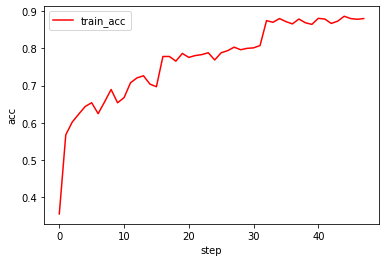

In [15]:
import matplotlib.pyplot as plt
fp16_training = True

if fp16_training:
    !pip install accelerate==0.2.0
    from accelerate import Accelerator
    accelerator = Accelerator(fp16=True)
    device = accelerator.device

def evaluate(data, output):
    answer = ''
    max_prob = float('-inf')
    num_of_windows = data[0].shape[1]
    
    for k in range(num_of_windows):
        # Obtain answer by choosing the most probable start position / end position
        start_prob, start_index = torch.max(output.start_logits[k], dim=0)
        end_prob, end_index = torch.max(output.end_logits[k], dim=0)
        
        # Probability of answer is calculated as sum of start_prob and end_prob
        prob = start_prob + end_prob
        
        # Replace answer if calculated probability is larger than previous windows
        if prob > max_prob:
          #Skip if start_index is larger than end_index 
          if start_index > end_index:
            continue
          else:
            max_prob = prob
            # Convert tokens to chars (e.g. [1920, 7032] --> "大 金")
            answer = tokenizer.decode(data[0][0][k][start_index : end_index + 1])
    
    # Remove spaces in answer (e.g. "大 金" --> "大金")
    return answer.replace(' ','') 

#parameters
fp16_training=True
EPOCH=3
LR=1e-4

model = BertForQuestionAnswering.from_pretrained("bert-base-chinese").to("cuda")
optimizer=AdamW(model.parameters(),lr=LR)

if fp16_training:
    model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader) 


train_acc_list=[]

for i in range(EPOCH):
    train_acc=0.0
    train_loss=0.0
    val_acc=0.0
    
    model.train()
    for j,data in enumerate(train_loader):
      data = [d.to("cuda") for d in data]
      
      # Model inputs: input_ids, token_type_ids, attention_mask, start_positions, end_positions (Note: only "input_ids" is mandatory)
      # Model outputs: start_logits, end_logits, loss (return when start_positions/end_positions are provided)
      output=model(input_ids=data[0], token_type_ids=data[1], attention_mask=data[2], start_positions=data[3], end_positions=data[4])
            
      start_index = torch.argmax(output.start_logits, dim=1)
      end_index = torch.argmax(output.end_logits, dim=1)
        
        
      train_acc += ((start_index == data[3]) & (end_index == data[4])).float().mean()
      train_loss += output.loss
        
      if fp16_training:
        accelerator.backward(output.loss)
      else:
        output.loss.backward()
        
      optimizer.step()
      optimizer.zero_grad()
      #Linear learning rate decay
      optimizer.param_groups[0]["lr"] -= LR/(1684*3)
        
      if((j+1)%100==0):
          train_acc=train_acc/100
          train_acc_list.append(train_acc.item())
          print("step ",(j+1)/100," train_acc:",train_acc.item(),' train_loss:',train_loss.item())
          train_acc=0.0
          train_loss=0.0
      
    model.eval()
    with torch.no_grad():
      for i, data in enumerate(dev_loader):
        output = model(input_ids=data[0].squeeze(dim=0).to(device), token_type_ids=data[1].squeeze(dim=0).to(device), attention_mask=data[2].squeeze(dim=0).to(device))
        val_acc += evaluate(data, output) == dev_questions[i]["answer_text"]
      val_acc=val_acc/len(dev_loader)
      val_acc_list.append(val_acc)
            
      print("val_acc:",val_acc)
      val_acc=0.0
      model.train()

plt.figure()
x=range(0,48)
plt.xlabel("step")
plt.ylabel("acc")
plt.plot(x,train_acc_list,color='r',label='train_acc')
plt.legend()
plt.show()          